# Исследование продаж в игровой индустрии

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Нам предстоит решить следующие **задачи**:
- Изучить статистику продаж игр на различных платформах на 4-м мировых рынках в период 1980-2016 гг.
- В датасете при необходимости исправить ошибки, привести данные к нужному типу, определить, в каких случаях выбросы будут мешать анализу.
- Определить период, в рамках которого мы можем определить закономерности жизненного цикла платформ.
- Определить лидеров среди платформ в актуальном периоде, посмотреть тенденции роста и паления продаж.
- Изучить влияние отзывов пользователей и критиков на продажи игр.
- Изучить популярность жанров игр.
- Изучить разницу в продажах в разных регионах (популярные платформы, жанры и разница в возрастных рейтингах, составление портрета "игрока региона".)
- Проверить гипотезы о сходстве/различии пользовательских рейтингов Xbox One и PC, а также от сходстве/различии рейтингов игровых жанров Action и Sports.
- Сформулировать общие выводы, а также идеи, которые позволят бизнесу принять решения о ставках на платформы и о планировании рекламных кампаний.

**Использованные данные**:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучение данных из файла

Импортируем датасет с данными о продажах игр.

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns

In [390]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [392]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [393]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем названия столбцов к нижнему регистру.

In [394]:
df.columns = df.columns.str.lower()

В столбце "name" - у 2-х строк нет названия игры (индексы 659, 14244), и этих же строк нет жанра. Подсчет уникальных значений в названиях показал, что некоторые игры приведены больше одного раза, но сравнение указанных строчек с теми, где названия есть, по показателям выручки не позволило провести аналогию с другими играми. Это значит, что 2-х названий мы не знаем (а ошибка могла возникнуть при переносе данных из одной базы в другую.) 

In [395]:
df['name'].value_counts()

Need for Speed: Most Wanted                         12
Ratatouille                                          9
LEGO Marvel Super Heroes                             9
FIFA 14                                              9
Madden NFL 07                                        9
                                                    ..
Jewels of the Tropical Lost Island                   1
Sherlock Holmes and the Mystery of Osborne House     1
The King of Fighters '95 (CD)                        1
Megamind: Mega Team Unite                            1
Haitaka no Psychedelica                              1
Name: name, Length: 11559, dtype: int64

In [396]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [397]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [398]:
df['name'] = df['name'].fillna('unknown')
df['genre'] = df['genre'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные столбца с годом релиза - в формате чисел с плавающей запятой. Также у нас есть пропущенные значения в 269 строках. Эти данные нам взять не откуда, поэтому заполняем "-1", а данные переводим в целочисленный тип. 

In [399]:
df['year_of_release'] = df['year_of_release'].fillna(-1)
df['year_of_release'] = df['year_of_release'].astype(int)

В столбце с оценками пользователей есть пропущенные данные, а также строки с текстом "tbd". TBD — сокращение от To Be Determined (или Decided.) Служит для отметки неясностей или пропусков, которые надо заполнить. Соответственно, переводим эти данные в NaN. А данные с оценками переводим в числа с плавающей точкой.

In [400]:
df['user_score'].value_counts(dropna=False)

NaN    6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

In [401]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)

In [402]:
df['user_score'] = df['user_score'].astype('float64')

In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


Посмотрим, есть ли в столбце с возрастным рейтингом неявные дубли

In [404]:
df['rating'].value_counts(dropna=False)

NaN     6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Проверим датасет на полные дубли

In [405]:
df.duplicated().sum()

0

Создадим столбец с **суммарными продажами** игр по регионам. Также создадим датасет с данными о суммарных продажах всех игр в 4-м регионах.

In [406]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [407]:
revenue_list = [{"territory":'na_sales_sum', "revenue_sum":df['na_sales'].sum()},\
                {"territory":'eu_sales_sum', "revenue_sum":df['eu_sales'].sum()},\
                {"territory":'jp_sales_sum', "revenue_sum":df['jp_sales'].sum()},\
                {"territory":'other_sales_sum', "revenue_sum":df['other_sales'].sum()}]
revenue_sum = pd.DataFrame(revenue_list)
display(revenue_sum)

,territory,revenue_sum
0,na_sales_sum,4402.35
1,eu_sales_sum,2424.67
2,jp_sales_sum,1297.37
3,other_sales_sum,791.32


В продажах закономерно лидирует Северная Америка, потом идет Евросоюз, далее Япония и остальные страны. 

**Результаты предобработки данных**:
- названия столбцов мы привели к нижнему регистру;
- нашли 2 строки с отсутствием данных о названии игры и другой информации;
- В жанрах и названиях игр отсутствующие значения заменили на "unknown";
- В годе релиза заменили отсутствующие данные на "-1", а все указанные данные привели к целочисленному типу;
- Оценки пользователей - заменили значения "tbd" на отсутствующие данные, а все указанные данные привели к целочисленному типу;
- Проверили рейтинги игра на наличие неявных дублей, а весь датасет - на наличие полных дублей;
- Создали столбец с суммарными продажами каждой игры, а также посчитали сумму продаж по регионам;

## Исследовательский анализ данных

Посчитаем распределение выпуска игр по годам. Примем каждую строку, как отдельное событие (при том, что у некоторых игр есть по несколько релизов и по платформам, и по годам.)

Text(0.5, 0, 'Годы.')

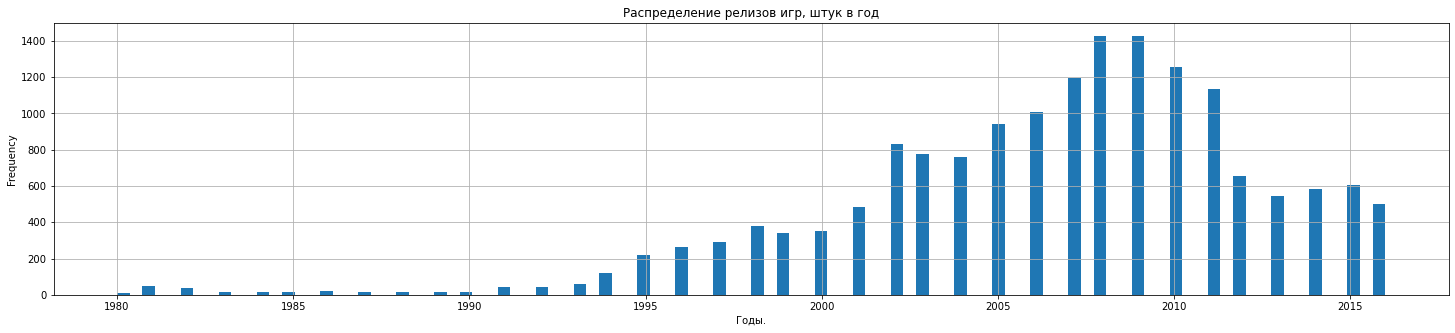

In [408]:
df[df['year_of_release'] > 0]['year_of_release']\
    .plot(kind='hist', bins=100, grid=True, figsize=(25,5))\
    .set_title('Распределение релизов игр, штук в год')
plt.xlabel("Годы.")

Если анализировать продажи игр по годам, то видно:
- до начала 90-х стабильно небольшие продажи (десятки штук.);
- подъем продаж в 1994, рост продаж в десятки раз;
- подьем в 2001, рост в несколько раз;
- спад после 2011-го до уровня начала 00-х. 

Если ограничивать период анализа, я бы не брал продажи до 1995-го года, когда начался рост "современных" продаж, связанных с технологическим и финансовым развитием индустрии. Также придется исключить строки с неизвестным годом выпуска (ок 1,6%). Актуальный период анализа определим позже.

Определим топ платформ про суммарным продажам. Также создадим столбец по количеству проданных наименований игр.

In [409]:
df_platforms_sum = df.pivot_table(index='platform', values='year_of_release', aggfunc='count')
df_platforms_sum['platform_sales'] = df.pivot_table(index='platform', values='sales', aggfunc='sum')
df_platforms_sum = df_platforms_sum.reset_index()
df_platforms_sum = df_platforms_sum.sort_values(by='platform_sales', ascending=False)
df_platforms_sum = df_platforms_sum.reset_index()
df_platforms_sum = df_platforms_sum.rename(columns={'year_of_release':'titles_quantity'})

df_platforms_sum

,index,platform,titles_quantity,platform_sales
0,16,PS2,2161,1255.77
1,28,X360,1262,971.42
2,17,PS3,1331,939.65
3,26,Wii,1320,907.51
4,4,DS,2151,806.12
5,15,PS,1197,730.86
6,6,GBA,822,317.85
7,18,PS4,392,314.14
8,19,PSP,1209,294.05
9,13,PC,974,259.52


На наш взгляд лидеры продаж - те платформы, которые перешли границу в 700 млн. копий. До этой границы продажи "растут" без скачков, а у 6-й по величине продаж палатформы - резкий отрыв от своего ближайшего конкурента (разница почти в 2 раза.)

In [410]:
df_platforms_sum_6 = df_platforms_sum[df_platforms_sum['platform_sales'] > 700]
df_platforms_sum_6

,index,platform,titles_quantity,platform_sales
0,16,PS2,2161,1255.77
1,28,X360,1262,971.42
2,17,PS3,1331,939.65
3,26,Wii,1320,907.51
4,4,DS,2151,806.12
5,15,PS,1197,730.86


In [411]:
df_top_6 = df[df['platform'].isin(df_platforms_sum_6['platform'])]
df_top_6.head()   

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


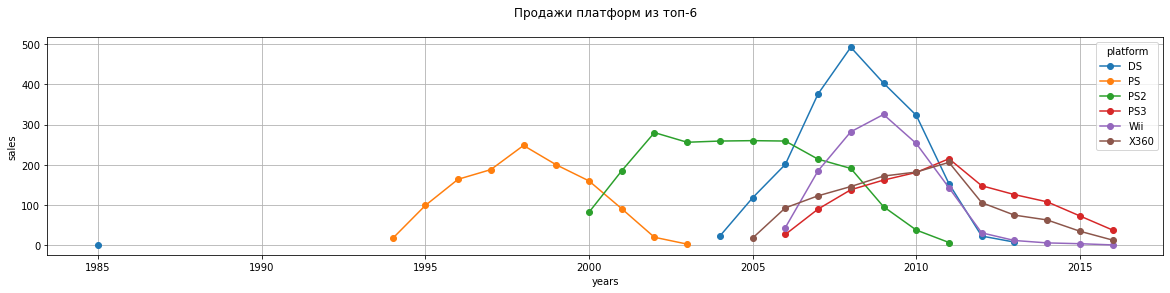

In [412]:
(df_top_6[df_top_6['year_of_release'] > 0]
 .pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='count')
 .T
 .plot(kind='line', figsize=(20,4),  style = 'o-', grid=True)
)
plt.title('Продажи платформ из топ-6'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

Судя по графикам продаж по годам среди самых популярных платформ, жизненный цикл (точнее, период популярности) составляет примерно 6-8 лет.

**Актуальным периодом** на примере топовых платформ я бы считал 2011-2016 - перед ним начинается рост сразу нескольких топовых платформ и приходятся пики нескольких топовых платформ, а в 2013 ясно видно, что спад продолжается 2-й год подряд, и после этого продажи только падают. Важно, что этот период близок к 2017-му, тренды которого мы хотим прогнозировать, а данные до 2011-го всё-таки уже избыточны для такого прогноза (хотя и позволяют увидеть жизненный цикл платформ.)

Изучим динамику продаж игр на платформах в период 2011-2016.

In [413]:
df_11_16 = df[df['year_of_release'] > 2010]
df_11_16.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60


In [414]:
df_11_16['platform'].value_counts()

PS3     708
3DS     512
X360    498
PSV     429
PS4     392
PC      389
PSP     312
XOne    247
Wii     197
DS      184
WiiU    147
PS2       7
Name: platform, dtype: int64

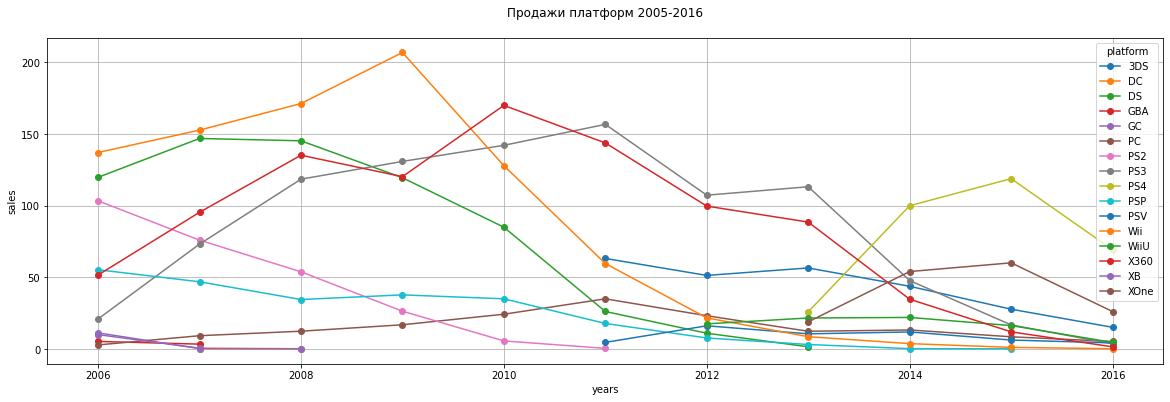

In [415]:
(df[df['year_of_release'] > 2005]
 .pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(20,6),  style = 'o-', grid=True)
)
plt.title('Продажи платформ 2005-2016'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

Видно, что на начало это периода приходится окончание жизненного цикла некоторых платформ. На середину - пики продаж еще нескольких наименований. В конце периода есть пара "выскочек", а у остальных - падение продаж. Посмотрим на данные после 2011-го года, чтобы оценить тренды периода, близкого к интересующему нас 2016-му, а также отсечь платформы, популярность которых в прошлом.

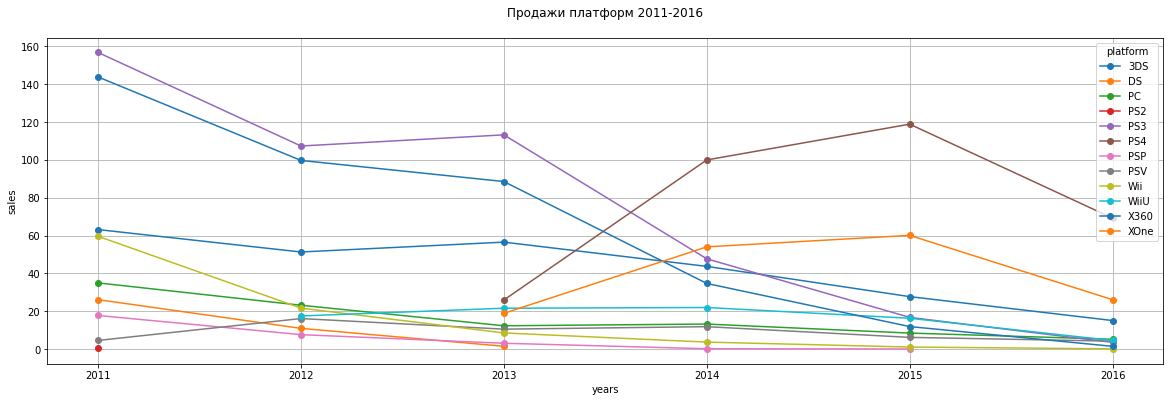

In [416]:
(df_11_16
 .pivot_table(index='platform', columns='year_of_release', values='sales', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(20,6),  style = 'o-', grid=True)
)
plt.title('Продажи платформ 2011-2016'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

In [417]:
df_2016 = df[df['year_of_release'] == 2016].pivot_table(index='platform', values='sales', aggfunc='sum')
df_2016.sort_values(by='sales', ascending=False)

,sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


Также посмотрим, что произошло с платформами к концу периода на 3-х разных территориях.

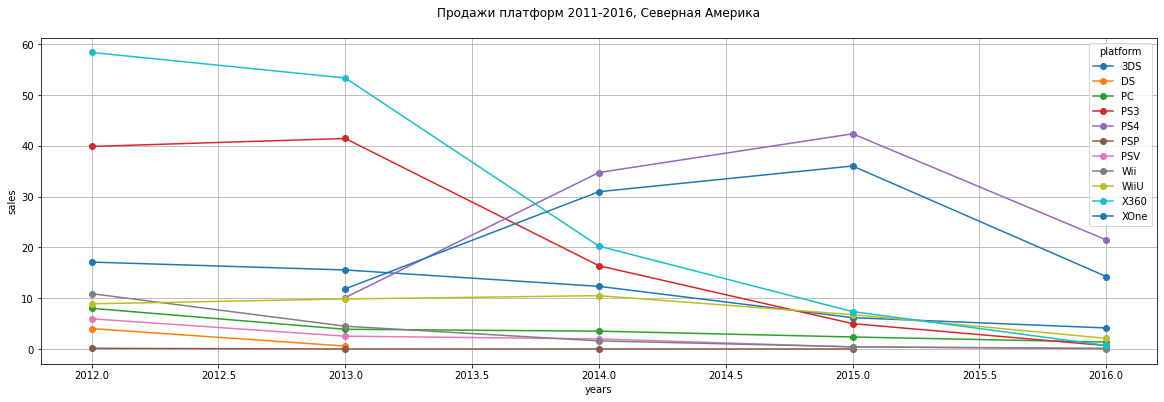

In [418]:
(df[df['year_of_release'] > 2011]
 .pivot_table(index='platform', columns='year_of_release', values='na_sales', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(20,6),  style = 'o-', grid=True)
)
plt.title('Продажи платформ 2011-2016, Северная Америка'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

In [419]:
df_2016 = df[df['year_of_release'] == 2016].pivot_table(index='platform', values='na_sales', aggfunc='sum')
df_2016.sort_values(by='na_sales', ascending=False)

,na_sales
platform,
PS4,21.49
XOne,14.27
3DS,4.14
WiiU,2.10
PC,1.36
X360,0.69
PS3,0.67
PSV,0.15
Wii,0.06


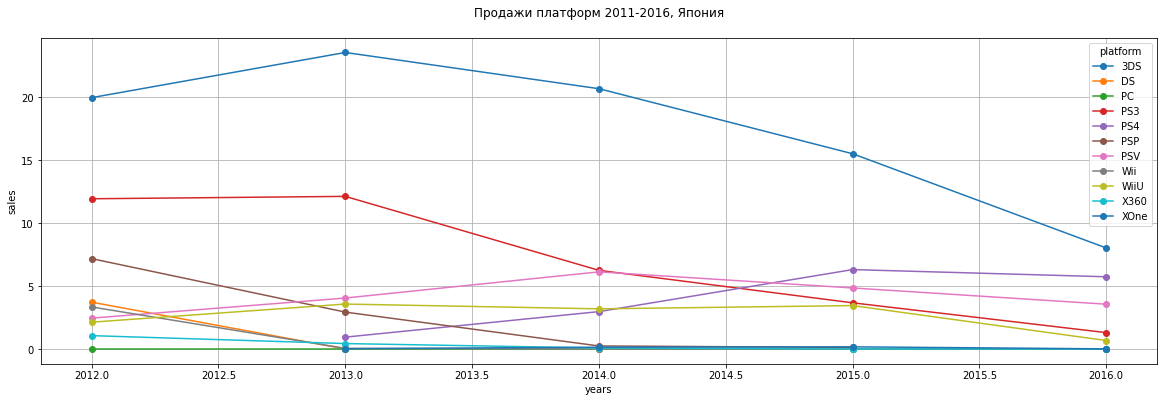

In [420]:
(df[df['year_of_release'] > 2011]
 .pivot_table(index='platform', columns='year_of_release', values='jp_sales', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(20,6),  style = 'o-', grid=True)
)
plt.title('Продажи платформ 2011-2016, Япония'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

In [421]:
df_2016 = df[df['year_of_release'] == 2016].pivot_table(index='platform', values='jp_sales', aggfunc='sum')
df_2016.sort_values(by='jp_sales', ascending=False)

,jp_sales
platform,
3DS,8.03
PS4,5.74
PSV,3.56
PS3,1.30
WiiU,0.67
XOne,0.01
PC,0.00
Wii,0.00
X360,0.00


In [422]:
# df_05_16_jp = df_05_16[df_05_16['year_of_release'] > 2011].pivot_table(index='platform', values='jp_sales', aggfunc='sum')
# df_05_16_jp.sort_values(by='jp_sales', ascending=False)

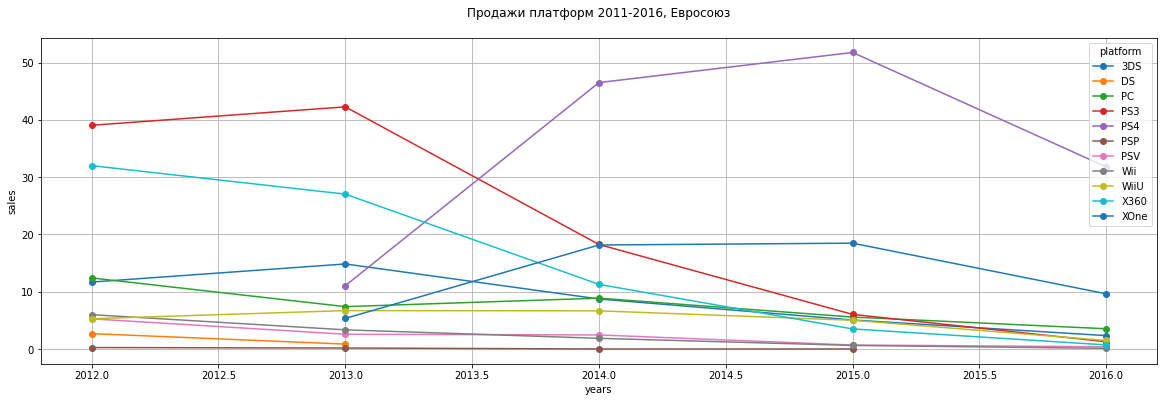

In [423]:
(df[df['year_of_release'] > 2011]
 .pivot_table(index='platform', columns='year_of_release', values='eu_sales', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(20,6),  style = 'o-', grid=True)
)
plt.title('Продажи платформ 2011-2016, Евросоюз'+ "\n")
plt.xlabel('years')
plt.ylabel('sales');

In [424]:
df_2016 = df[df['year_of_release'] == 2016].pivot_table(index='platform', values='eu_sales', aggfunc='sum')
df_2016.sort_values(by='eu_sales', ascending=False)

,eu_sales
platform,
PS4,31.78
XOne,9.63
PC,3.53
3DS,2.33
WiiU,1.48
PS3,1.26
X360,0.71
PSV,0.39
Wii,0.11


- В период 2005-2016 лидировали такие **платформы**, как X360, PS3, Wii, DS. Пики их продаж пришлись на 2009-2011, но к концу актуального периода все они пошли на спад. Надежды на их возрождение или успех в 2017-м минимальны.
- Если говорить о **конце** актуального периода, сложно однозначно выделить потенциальных лидеров или тех, кому предстоит вырасти в ближайший после 2016-го года период. Дело в том, что все платформы демонстрируют **падение** к 2016-му, ни одна из них не растет. Можно обратить внимание на **PS4**, она стартовала в 2013-м, продемонстрировала пик в 2015-м, потом продажи снизились, но в последний отчетный период она самая популярная их всех, кто еще на рынке + у нее большой отрыв от конкурентов.
- У **XOne** более плавная кривая продаж, и их сумма меньше в 2,5 раза, чем у лидера. Тем не менее это второе место по состоянию на 2016-й. За этой платформой тоже можно следить, предполагая вероятность роста. 
- **3DS** закончила 2016 на падении, и снижение она демонстрирует с 2013-го. Вряд ли в будущем она резко рванет вверх. 
- Остальные платформы тоже склонны к снижению, к тому же их результаты в 2016-м были не большими, каждая из них продала в несколько раз меньше вышеупомянутых платформ. Вряд ли они станут темными лошадками, которые смогут стать чемпионами в будущем. 
- На **американском рынке** тенденции, близкие к суммарным продажам. При этом разрыв между XOne и PS4 меньше, чем на остальных территориях.
- На **японском рынке** интересен случай XOne, которая росла до 2015, а в 2016-м было совсем небольшое снижение, более похожее на плато. Есть шанс, что на этом рынке у нее есть шансы к росту в рамках цикла 6-7 лет. Также обратим внимание на судьбу 3DS, которая падает уже несколько лет, но в 2016-м на этом рынке обходит остальные платформы. 
- На **европейском** рынке интересно будет посмотреть судьбу PS4, у нее здесь высокий пик в 2015-м, и большой отрыв от  XOne (в 2016м у них разница в 3 раза!) На этом рынке у нее вряд ли уже будет большой подъем, но можно сделать ставку на плато на несколько лет, либо на плавное снижение с длинным хвостом, что будет означать хорошие продажи в сумме за все годы. Упомянем, что ранее были 2 примера с ростом после падения (у платформ PS3 и Wii были 2 пика в продажах.) Может быть именно Европа позволит PS4 выйти еще на один пик. 

Построим диаграмму размаха для суммарных продаж по всем платформам за актуальный период. По медианам количества продаж лидируют X360, XOne, WiiU. По величине стандартного отклонения продаж выделим X360, PS3, PS4, XOne. Интересно, что по абсолютным цифрам количества наименований игр XOne и WiiU - далеко не чемпионы (получается на них игры продаются в среднем дороже и при этом с бОльшим разбросом в количестве продаж.) Также интересно, что 3DS (один лидеров по количеству наименований игр) в среднем продает их дешевле и с относительно небольшим разбросом в количестве продаж. 

In [425]:
print('Максимальный уровень продаж, млн:', df_11_16['sales'].max())

Максимальный уровень продаж, млн: 21.05


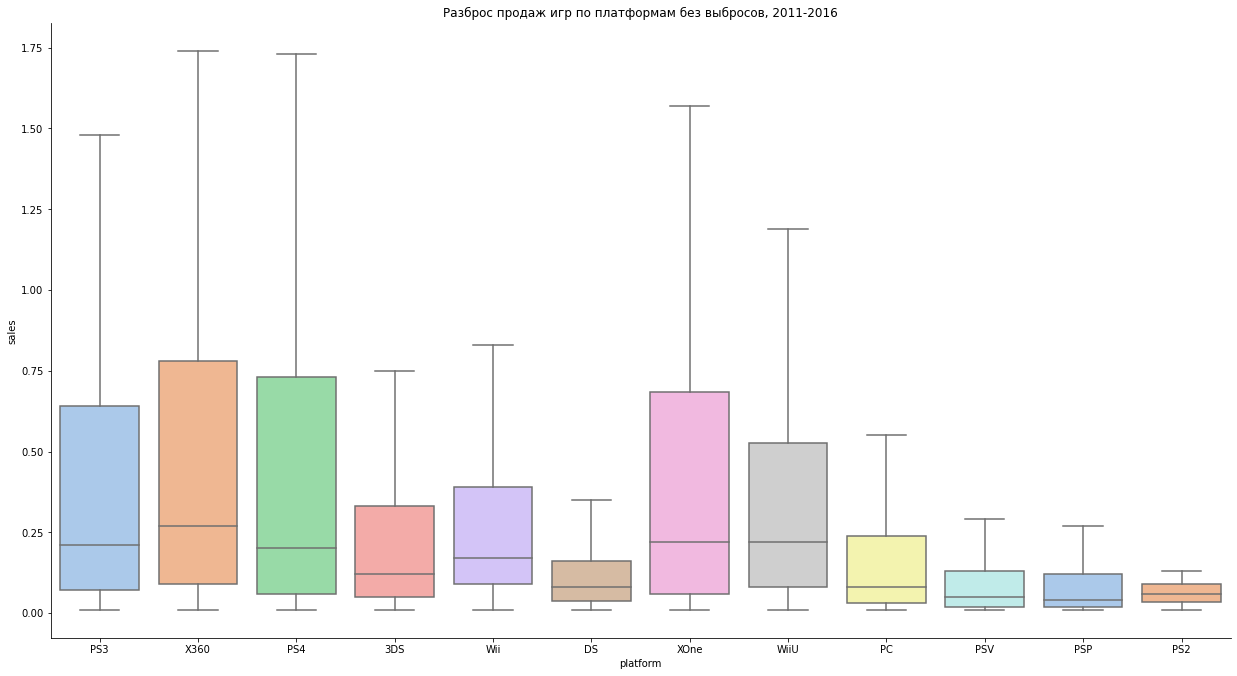

In [426]:
for column in ['sales']:    
    g = sns.catplot(y=column, x='platform', kind="box", data= df_11_16, palette = 'pastel', showfliers=False)
    g.fig.set_figwidth(20)
    g.fig.set_figheight(10)
    
g.set(title = "Разброс продаж игр по платформам без выбросов, 2011-2016")

<div class="alert alert-success">
<h2> Комментарий ревьюера 👍<a class="tocSkip"> </h2>

Отличный график! можно было бы сделать еще одини доп.график, чтобы посмотреть на выбросы (потому что выбросы - это игры-бестселлеры; возможно могла бы быть полезной информация о том, у каких платформ таких бестселлеров больше), но это совсем необязательно

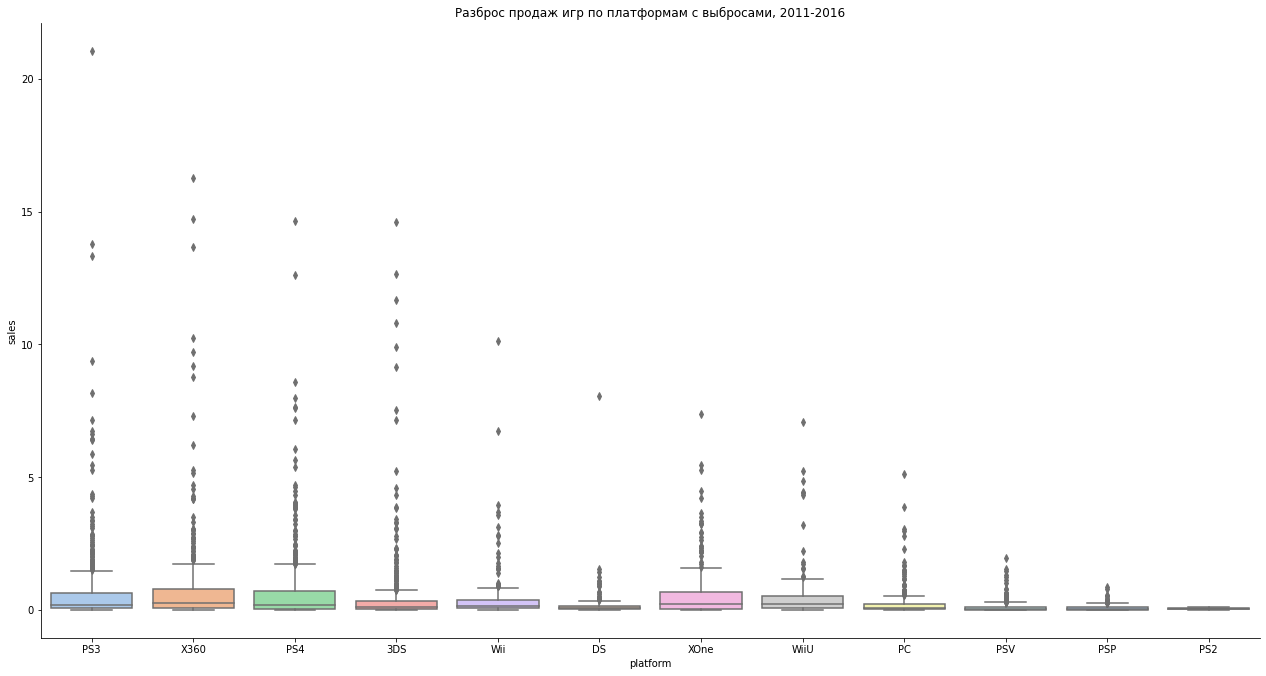

In [427]:
for column in ['sales']:    
    g = sns.catplot(y=column, x='platform', kind="box", data= df_11_16, palette = 'pastel')
    g.fig.set_figwidth(20)
    g.fig.set_figheight(10)
    
g.set(title = "Разброс продаж игр по платформам с выбросами, 2011-2016")

Если посмотреть на выбросы на диаграммах размаха, можно выделить PS3 (одна из игр продалась в количестве 21 миллион шт!), X360, PS4, 3DS. Последняя, хоть и продает игры дешевле и с меньшим, чем у других, стандартным отклонением, но также имеет игры-бестселлеры в своем каталоге. 

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами пользователей и критиков и продажами.

Text(0.5, 1.0, 'Взаимосвязь продаж на PS4 и оценок критиков\n')

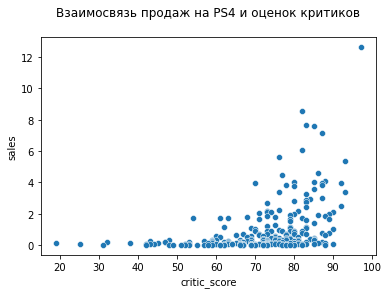

In [428]:
df_ps_4_11_16 = df_11_16[df_11_16['platform'] == 'PS4']
sns.scatterplot(data=df_11_16[df_11_16['platform'] == 'PS4'], x="critic_score", y="sales")
plt.title('Взаимосвязь продаж на PS4 и оценок критиков'+ "\n")

In [429]:
print('Корреляция продаж на PS4 и оценок критиков:', df_ps_4_11_16['critic_score'].corr(df_ps_4_11_16['sales']))

Корреляция продаж на PS4 и оценок критиков: 0.40656790206178095


Text(0.5, 1.0, 'Взаимосвязь продаж на PS4 и оценок пользователей\n')

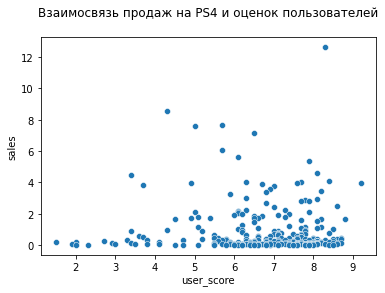

In [430]:
sns.scatterplot(data=df_11_16[df_11_16['platform'] == 'PS4'], x="user_score", y="sales")
plt.title('Взаимосвязь продаж на PS4 и оценок пользователей'+ "\n")

In [431]:
print('Корреляция продаж на PS4 и оценок пользователей:', df_ps_4_11_16['user_score'].corr(df_ps_4_11_16['sales']))

Корреляция продаж на PS4 и оценок пользователей: -0.031957110204556424


Отзывы критиков влияют на рост продаж, но на среднем уровне. А в случае влияния оценок пользователей обнаружена очень небольшая отрицательная корреляция.

Посмотрим взаимосвязь таких оценок и продаж у самых популярных платформ за весь период.

In [432]:
print('Корреляция продаж на DS и оценок пользователей:', df_top_6.query('platform == "DS"')['user_score']\
      .corr(df_top_6.query('platform == "DS"')['sales']))
print('Корреляция продаж на PS и оценок пользователей:', df_top_6.query('platform == "PS"')['user_score']\
      .corr(df_top_6.query('platform == "PS"')['sales']))
print('Корреляция продаж на PS2 и оценок пользователей:', df_top_6.query('platform == "PS2"')['user_score']\
      .corr(df_top_6.query('platform == "PS2"')['sales']))
print('Корреляция продаж на PS3 и оценок пользователей:', df_top_6.query('platform == "PS3"')['user_score']\
      .corr(df_top_6.query('platform == "PS3"')['sales']))
print('Корреляция продаж на Wii и оценок пользователей:', df_top_6.query('platform == "Wii"')['user_score']\
      .corr(df_top_6.query('platform == "Wii"')['sales']))
print('Корреляция продаж на X360 и оценок пользователей:', df_top_6.query('platform == "X360"')['user_score']\
      .corr(df_top_6.query('platform == "X360"')['sales']))


Корреляция продаж на DS и оценок пользователей: 0.13043550111642488
Корреляция продаж на PS и оценок пользователей: 0.29797783612684925
Корреляция продаж на PS2 и оценок пользователей: 0.17286551112058182
Корреляция продаж на PS3 и оценок пользователей: 0.12669133936341706
Корреляция продаж на Wii и оценок пользователей: 0.11241436067003167
Корреляция продаж на X360 и оценок пользователей: 0.1144588297845418


In [433]:
print('Корреляция продаж на DS и оценок критиков:', df_top_6.query('platform == "DS"')['critic_score']\
      .corr(df_top_6.query('platform == "DS"')['sales']))
print('Корреляция продаж на PS и оценок критиков:', df_top_6.query('platform == "PS"')['critic_score']\
      .corr(df_top_6.query('platform == "PS"')['sales']))
print('Корреляция продаж на PS2 и оценок критиков:', df_top_6.query('platform == "PS2"')['critic_score']\
      .corr(df_top_6.query('platform == "PS2"')['sales']))
print('Корреляция продаж на PS3 и оценок критиков:', df_top_6.query('platform == "PS3"')['critic_score']\
      .corr(df_top_6.query('platform == "PS3"')['sales']))
print('Корреляция продаж на Wii и оценок критиков:', df_top_6.query('platform == "Wii"')['critic_score']\
      .corr(df_top_6.query('platform == "Wii"')['sales']))
print('Корреляция продаж на X360 и оценок критиков:', df_top_6.query('platform == "X360"')['critic_score']\
      .corr(df_top_6.query('platform == "X360"')['sales']))

Корреляция продаж на DS и оценок критиков: 0.23637945738859714
Корреляция продаж на PS и оценок критиков: 0.44563998586242454
Корреляция продаж на PS2 и оценок критиков: 0.3954345494545488
Корреляция продаж на PS3 и оценок критиков: 0.43243156856420617
Корреляция продаж на Wii и оценок критиков: 0.1775598880608996
Корреляция продаж на X360 и оценок критиков: 0.39373586530725874


Если говорить о платформах из топ-6, то во всех случаях мы видим **положительные** корреляции в диапазоне от 0.11 до 0.44. Максимальная корреляция у платформы PS и отзывов критиков. Таким образом отзывы критиков и отзывы пользователей **связаны** с ростом продаж игр на разных платформах, но влияние оценок не очень велико.

Посмотрим на общее распределение игр по жанрам. 

In [434]:
df_11_16_genre = df_11_16.groupby(['name', 'genre'])['sales'].sum()
df_11_16_genre = df_11_16_genre.reset_index()
df_11_16_genre.head()

,name,genre,sales
0,Beyblade Burst,Role-Playing,0.03
1,Fire Emblem Fates,Role-Playing,1.67
2,Frozen: Olaf's Quest,Platform,1.10
3,Haikyu!! Cross Team Match!,Adventure,0.04
4,Tales of Xillia 2,Role-Playing,0.84


In [435]:
df_11_16_genre['genre'].value_counts()

Action          695
Role-Playing    340
Adventure       303
Misc            271
Sports          160
Shooter         149
Simulation      110
Strategy         96
Fighting         87
Racing           74
Platform         71
Puzzle           63
Name: genre, dtype: int64

In [436]:
df_11_16_genre_sales = df_11_16.groupby('genre')['sales'].sum().sort_values(ascending=False)
df_11_16_genre_sales = df_11_16_genre_sales.reset_index()
df_11_16_genre_sales

,genre,sales
0,Action,557.80
1,Shooter,402.91
2,Role-Playing,245.63
3,Sports,237.15
4,Misc,139.42
5,Platform,88.68
6,Racing,88.31
7,Fighting,66.90
8,Simulation,50.26
9,Adventure,45.04


In [437]:
df_11_16_name_sales = df_11_16.groupby(['name', 'genre'])['sales'].sum().sort_values(ascending=False)
df_11_16_name_sales = df_11_16_name_sales.reset_index()
df_11_16_name_sales.head(10)


,name,genre,sales
0,Grand Theft Auto V,Action,56.58
1,Call of Duty: Modern Warfare 3,Shooter,30.60
2,Call of Duty: Black Ops II,Shooter,29.40
3,Call of Duty: Ghosts,Shooter,27.39
4,Call of Duty: Black Ops 3,Shooter,25.67
5,Minecraft,Misc,24.16
6,Call of Duty: Advanced Warfare,Shooter,21.97
7,The Elder Scrolls V: Skyrim,Role-Playing,21.14
8,FIFA 15,Sports,17.37
9,Battlefield 3,Shooter,17.27


In [438]:
df_11_16_genre_sales = df_11_16.groupby('genre')['sales'].median().sort_values(ascending=False)
df_11_16_genre_sales = df_11_16_genre_sales.reset_index()
df_11_16_genre_sales = df_11_16_genre_sales.rename(columns={'sales':'sales_median'})
df_11_16_genre_sales

,genre,sales_median
0,Shooter,0.410
1,Sports,0.200
2,Platform,0.185
3,Fighting,0.180
4,Racing,0.160
5,Role-Playing,0.150
6,Action,0.130
7,Misc,0.130
8,Simulation,0.110
9,Strategy,0.080


- По **количеству наименований** лидируют жанры Action, Adventure, Role-Playing, Sports. 
- По **продажам** к лидерам присоединяется Shooter, а вот Adventure в рейтинге опускается в конец первой десятки. 
- Если посмотреть **10** самых популярных игр, то они принадлежат к жанрам Shooter (6 игр из 10!), Sports, Action, RPG, Shooter.
- Если смотреть распределение **медианных продаж** по жанрам, то самые большие продажи в пересчете на игру - в жанрах Shooter, Platform, Sports, Racing. Также в пятерку попадает Fighting. 

## Портрет пользователя каждого региона (NA, EU, JP)

Самые популярные платформы (топ-5)

In [439]:
df_5 = df_11_16.groupby('platform')['sales'].sum().sort_values(ascending=False).head(5)
df_5 = df_5.reset_index()
df_5['sales_share'] = df_5['sales'] / df_5['sales'].sum()
df_5

,platform,sales,sales_share
0,PS3,445.57,0.286132
1,X360,380.38,0.244269
2,PS4,314.14,0.201731
3,3DS,257.81,0.165558
4,XOne,159.32,0.102311


Платформы Северной Америки.

In [440]:
df_na_5 = df_11_16.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
df_na_5 = df_na_5.reset_index()
df_na_5['sales_share'] = df_na_5['na_sales'] / df_na_5['na_sales'].sum()
df_na_5

,platform,na_sales,sales_share
0,X360,226.80,0.333740
1,PS3,168.26,0.247598
2,PS4,108.74,0.160013
3,XOne,93.12,0.137028
4,3DS,82.65,0.121621


Платформы Евросоюза.

In [441]:
df_eu_5 = df_11_16.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
df_eu_5 = df_eu_5.reset_index()
df_eu_5['sales_share'] = df_eu_5['eu_sales'] / df_eu_5['eu_sales'].sum()
df_eu_5

,platform,eu_sales,sales_share
0,PS3,163.10,0.302452
1,PS4,141.09,0.261636
2,X360,117.10,0.217149
3,3DS,61.27,0.113619
4,PC,56.70,0.105144


Платформы Японии.

In [442]:
df_jp_5 = df_11_16.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
df_jp_5 = df_jp_5.reset_index()
df_jp_5['sales_share'] = df_jp_5['jp_sales'] / df_jp_5['jp_sales'].sum()
df_jp_5

,platform,jp_sales,sales_share
0,3DS,100.62,0.474959
1,PS3,49.39,0.233137
2,PSP,24.04,0.113477
3,PSV,21.84,0.103092
4,PS4,15.96,0.075336


Самое главное отличие - на рынке Японии предпочитают портативные консоли 3DS, PSP и PSV а в топ-5 не попали X360 и XOne. Видно, что пользователи в Японии играют на "ходу". Европейские и американские вкусы в целом схожи. Отличие в XOne, которая не попала в европейский топ-5 и "заменена" в Европе на PC.

Самые популярные жанры по регионам (топ-5).

In [443]:
df_genre_5 = df_11_16.groupby('genre')['sales'].sum().sort_values(ascending=False).head(5)
df_genre_5 = df_genre_5.reset_index()
df_genre_5['sales_share'] = df_genre_5['sales'] / df_5['sales'].sum()
df_genre_5

,genre,sales,sales_share
0,Action,557.80,0.358202
1,Shooter,402.91,0.258737
2,Role-Playing,245.63,0.157736
3,Sports,237.15,0.152291
4,Misc,139.42,0.089531


Жанры Северной Америки.

In [444]:
df_genre_na_5 = df_11_16.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
df_genre_na_5 = df_genre_na_5.reset_index()
df_genre_na_5['sales_share'] = df_genre_na_5['na_sales'] / df_genre_na_5['na_sales'].sum()
df_genre_na_5

,genre,na_sales,sales_share
0,Action,230.92,0.335874
1,Shooter,194.43,0.282799
2,Sports,108.70,0.158104
3,Role-Playing,83.78,0.121858
4,Misc,69.69,0.101364


Жанры Евросоюза.

In [445]:
df_genre_eu_5 = df_11_16.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
df_genre_eu_5 = df_genre_eu_5.reset_index()
df_genre_eu_5['sales_share'] = df_genre_eu_5['eu_sales'] / df_genre_eu_5['eu_sales'].sum()
df_genre_eu_5

,genre,eu_sales,sales_share
0,Action,199.12,0.369768
1,Shooter,148.02,0.274875
2,Sports,88.48,0.164308
3,Role-Playing,62.30,0.115692
4,Racing,40.58,0.075357


Жанры Японии.

In [446]:
df_genre_jp_5 = df_11_16.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)
df_genre_jp_5 = df_genre_jp_5.reset_index()
df_genre_jp_5['sales_share'] = df_genre_jp_5['jp_sales'] / df_genre_jp_5['jp_sales'].sum()
df_genre_jp_5

,genre,jp_sales,sales_share
0,Role-Playing,79.87,0.430334
1,Action,63.62,0.342780
2,Misc,17.60,0.094828
3,Fighting,12.38,0.066703
4,Platform,12.13,0.065356


Посмотрим на топы игр по территориям

Топ игр, Северная Америка

In [447]:
df_11_16_name_na_sales = df_11_16.groupby(['name', 'genre'])['na_sales'].sum().sort_values(ascending=False)
df_11_16_name_na_sales = df_11_16_name_na_sales.reset_index()
df_11_16_name_na_sales.head(10)

,name,genre,na_sales
0,Grand Theft Auto V,Action,23.84
1,Call of Duty: Modern Warfare 3,Shooter,15.54
2,Call of Duty: Ghosts,Shooter,14.94
3,Call of Duty: Black Ops II,Shooter,14.08
4,Call of Duty: Black Ops 3,Shooter,12.25
5,Minecraft,Misc,11.28
6,Call of Duty: Advanced Warfare,Shooter,10.51
7,The Elder Scrolls V: Skyrim,Role-Playing,9.65
8,Battlefield 3,Shooter,8.20
9,Just Dance 3,Misc,7.75


Топ игр, Евросоюз

In [448]:
df_11_16_name_eu_sales = df_11_16.groupby(['name', 'genre'])['eu_sales'].sum().sort_values(ascending=False)
df_11_16_name_eu_sales = df_11_16_name_eu_sales.reset_index()
df_11_16_name_eu_sales.head(10)

,name,genre,eu_sales
0,Grand Theft Auto V,Action,23.42
1,FIFA 15,Sports,12.02
2,Call of Duty: Modern Warfare 3,Shooter,11.15
3,FIFA 16,Sports,11.09
4,FIFA 14,Sports,10.96
5,Call of Duty: Black Ops II,Shooter,10.84
6,FIFA Soccer 13,Action,10.16
7,Call of Duty: Black Ops 3,Shooter,9.49
8,Call of Duty: Ghosts,Shooter,8.89
9,Minecraft,Misc,8.75


Топ игр, Япония

In [449]:
df_11_16_name_jp_sales = df_11_16.groupby(['name', 'genre'])['jp_sales'].sum().sort_values(ascending=False)
df_11_16_name_jp_sales = df_11_16_name_jp_sales.reset_index()
df_11_16_name_jp_sales.head(10)

,name,genre,jp_sales
0,Animal Crossing: New Leaf,Simulation,4.39
1,Pokemon X/Pokemon Y,Role-Playing,4.35
2,Monster Hunter 4,Role-Playing,3.44
3,Super Smash Bros. for Wii U and 3DS,Fighting,3.24
4,Yokai Watch 2 Ganso/Honke,Role-Playing,3.18
5,Pokemon Black 2/Pokemon White 2,Role-Playing,3.14
6,Pokemon Omega Ruby/Pokemon Alpha Sapphire,Role-Playing,3.10
7,Monster Hunter X,Action,2.79
8,Mario Kart 7,Racing,2.69
9,Yokai Watch 2 Shinuchi,Role-Playing,2.68


- По **количеству наименований** лидируют жанры Action, Adventure, Role-Playing, Sports. По **продажам** к лидерам присоединяется Shooter, а вот Adventure уходит из топ-5.
- Если посмотреть **10 самых популярных** игр, то они принадлежат к жанрам Sports, Action, Racing, Shooter.
- По регионам топы жанров игр в **Америке и Европы** схожи за исключением популярности Racing в Европе. Причем изучение названий игр показывает, что в Европе в плане спорта выбирают футбол, а в Северной Америке в топ игр спортивные вообще не попадают, зато бестселеры - шутеры и GTA.
- В **Японии** совершенно иные предпочтения - в топе RPG (включая 6 мест в 10-ке названий игр), платформенные игры (последних нет в топах-5 остальных территорий, а также Action (что сближает с другими регионами) и Fighting.

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Введем числовые аналоги возрастных рейтингов (укажем возраст, для которого разрешена игра.)

- E - 3
- T- 13
- M - 17
- E10+ - 10
- EC - 4 (в описании возраст не указан, указаны только требования по ограничению, но будем считать, что это следующая ступень после E)
- K-A - 0 (не смог найти описание)
- RP - 0 (возрастной статус не определен)
- AO - 18

In [450]:
def age_category(df_11_16):
    rating = df_11_16['rating']
    if rating == 'E':
        return '3'
    if rating == 'T':
        return '13'
    if rating == 'M':
        return '17'
    if rating == 'E10+':
        return '10'
    if rating == 'EC':
        return '4'
    if rating == 'AO':
        return '18'
    return 'no rating'

df_11_16['age_category'] = df_11_16.apply(age_category, axis=1)
# df_11_16

C:\Users\dsaulin\AppData\Local\Temp/ipykernel_14364/2318202391.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11_16['age_category'] = df_11_16.apply(age_category, axis=1)


Распределение продаж по возрастным рейтингам, все территории

In [451]:
df_11_16['age_category'].value_counts()

no rating    1709
17            622
3             618
13            616
10            456
4               1
Name: age_category, dtype: int64

Из всех возрастных рейтингов 4-ка самых популярных - для 3, 10, 13 и 17 лет. На игры с этими возрастными рейтингами приходится подавляющее большинство всех продаж.

Распределение продаж по возрастным рейтингам, Северная Америка

In [452]:
print(df_11_16.groupby('age_category')['na_sales'].sum().sort_values(ascending=False))

age_category
17           308.45
3            170.17
no rating    123.69
10           117.72
13           109.31
4              0.42
Name: na_sales, dtype: float64


Распределение продаж по возрастным рейтингам, Евросоюз

In [453]:
print(df_11_16.groupby('age_category')['eu_sales'].sum().sort_values(ascending=False))

age_category
17           250.26
3            141.73
no rating    116.64
13            83.16
10            78.00
4              0.00
Name: eu_sales, dtype: float64


Распределение продаж по возрастным рейтингам, Япония

In [454]:
print(df_11_16.groupby('age_category')['jp_sales'].sum().sort_values(ascending=False))

age_category
no rating    138.21
3             36.68
13            33.39
17            26.14
10            11.23
4              0.00
Name: jp_sales, dtype: float64


- Самые популярные рейтинги в **Северной Америке и Европе** распределились одинаково - сначала для самых старших (17 лет), потом для самых маленьких (3 года), потом уже для подростков 10 и 13 лет. Также в обоих случаях игры с непроставленным рейтингом - на третьих местах (причины отсутствия возрастной маркировки в нашем датасете нам неизвестны.)
- Разница **японского топа** в том, безрейтинговые игры на первых местах (тут надо вспомнить склонность пользоватлей к платформеным играм, а в их случае, возможно, не такие жесткие правила маркировки), потом -младший возраст, потом 13 лет, потом старший (17). Т.е. в Японии пользователи раннего подросткового возраста и семейные покупатели активнее 17-летних. 
- Относительно влияния рейтиннга на продажи - видно, что самые популярные игры на всех территориях - для младшего и подросткового возраста. Причем в Японии наиболее активны 13-летние потребители, а в Америке и Европы - старшие по возрасту юзеры. 

**Портреты потребителей регионов**:
- **Северная Америка** - пользователи приставок Microsoft и Sony, предпочитающие игры для младшего возраста, а также игры с высоким возрастным цензом, которые играют в шутеры и экшн-игры, а также увлечены спортивными симуляторами и RPG.
- **Европа** - любители Sony, Microsoft и Nintendo, предпочитающие игры для младшего возраста, а также игры с высоким возрастным цензом, которые играют в шутеры и экшн-игры, футбольные симуляторы и гонки, а также RPG.
- **Япония** - фанаты консольных приставок Nintendo и Sony, а также приставок Sony, предпочитающие игры для младшего возраста и младшего подросткового возраста в жанрах RPG, экшн и платформенных стилях и Fighting. Явно выраженное предпочтение к играм и приставкам "на ходу" и в дороге.

## Проверка гипотез

Сформулируем гипотезы исследования.

1) H0: Средние пользовательские рейтинги платформ Xbox One и PC не различаются.

H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

2) H0: Средние пользовательские рейтинги жанров Action и Sports не различаются.

H1: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [455]:
alpha = .05

results = st.ttest_ind(
    df_11_16[df_11_16['platform'] == 'XOne']['user_score'], 
    df_11_16[df_11_16['platform'] == 'PC']['user_score'], nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.6267602271422317
Не получилось отвергнуть нулевую гипотезу


In [456]:
alpha = .05

results = st.ttest_ind(
    df_11_16[df_11_16['genre'] == 'Action']['user_score'], 
    df_11_16[df_11_16['genre'] == 'Sports']['user_score'], nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.197455025213706e-24
Отвергаем нулевую гипотезу


Если анализировать актуальный период, то мы получаем следующий результат. Значение p-value в **первом** случае показывает, что вероятность получить близкие средние в пользовательских рейтингах Xbox One и PC весьма велика, а значит нулевую гипотезу **мы не отвергаем**. Во **втором** случае вероятность получить близкие средние в пользовательских рейтингах жанров Action и Sports крайне мала, и мы **отвергаем** нулевую гипотезу.

In [457]:
print(df_11_16[df_11_16['platform'] == 'XOne']['user_score'].mean())
print(df_11_16[df_11_16['platform'] == 'PC']['user_score'].mean())
print('Разница в средних в процентах:', (df_11_16[df_11_16['platform'] == 'PC']['user_score'].mean() - df_11_16[df_11_16['platform'] == 'XOne']['user_score'].mean()) / df_11_16[df_11_16['platform'] == 'XOne']['user_score'].mean() * 100)

6.52142857142857
6.451791530944625
Разница в средних в процентах: -1.0678188026015567


In [458]:
print(df_11_16[df_11_16['genre'] == 'Action']['user_score'].mean())
print(df_11_16[df_11_16['genre'] == 'Sports']['user_score'].mean())
print('Разница в средних в процентах:', (df_11_16[df_11_16['genre'] == 'Action']['user_score'].mean() - df_11_16[df_11_16['genre'] == 'Sports']['user_score'].mean()) / df_11_16[df_11_16['genre'] == 'Sports']['user_score'].mean() * 100)

6.775903614457846
5.650813008130081
Разница в средних в процентах: 19.910243087305247


## Общие выводы

- В продажах игр лидирует Северная Америка, потом идет Евросоюз, далее Япония и остальные страны.
- Жизненный цикл игровой платформы, точнее период её популярности составляет примерно 6-8 лет. При этом могут быть длинные хвосты продаж и после пиков. 
- Актуальным периодом для прогнозирования трендов мы выбрали 2011-2016, чтобы оценить тренды периода, близкого к интересующему нас 2016-му, а также отсечь платформы, популярность которых в прошлом.
- В период 2005-2016 лидировали такие платформы, как X360, PS3, Wii, DS (производители Microsoft, Sony, Nintendo). Пики их продаж пришлись на 2009-2011, но к концу актуального периода все они пошли на спад. Надежды на их возрождение или успех после 2016-го минимальны.
- Сложно однозначно выделить потенциальных лидеров или тех, кому предстоит вырасти в ближайший после 2016-го года период. Дело в том, что все платформы демонстрируют падение к 2016-му, ни одна из них не растет.
- Можно обратить внимание на PS4, она стартовала в 2013-м, продемонстрировала пик в 2015-м, потом продажи снизились, но в последний отчетный период она самая популярная их всех, кто еще на рынке + у нее большой отрыв от конкурентов.
- У XOne более плавная кривая продаж, и их сумма меньше в 2,5 раза, чем у лидера. Тем не менее это второе место по состоянию на 2016-й. За этой платформой тоже можно следить, предполагая вероятность роста.
- На японском рынке интересен случай XOne - есть шанс, что на этом рынке у нее есть возможности к росту в рамках цикла 6-7 лет. Также обратим внимание на судьбу 3DS, которая падает уже несколько лет, но в 2016-м на этом рынке обходит остальные платформы.
- На европейском рынке интересно будет посмотреть судьбу PS4 - у нее вряд ли уже будет большой подъем, но можно сделать ставку на плато на несколько лет, либо на плавное снижение с длинным хвостом, что будет означать хорошие продажи в сумме за все годы. 
- По медианам количества продаж лидируют X360, XOne, WiiU. По величине стандартного отклонения продаж выделим X360, PS3, PS4, XOne.  Интересно, что по абсолютным цифрам количества наименований игр XOne и WiiU - далеко не чемпионы (получается на них игры продаются в среднем дороже и при этом с бОльшим разбросом в количестве продаж.) Также интересно, что 3DS (один лидеров по количеству наименований игр) в среднем продает их дешевле и с относительно небольшим разбросом в количестве продаж.
- Если посмотреть на выбросы на диаграммах размаха, можно выделить PS3 (одна из игр продалась в количестве 21 миллион шт!), X360, PS4, 3DS. Последняя, хоть и продает игры дешевле и с меньшим, чем у других, стандартным отклонением, но также имеет игры-бестселлеры в своем каталоге.
- Отзывы критиков и отзывы пользователей влияют на рост продаж игр на разных платформах, но корреляция часто очень мала, иногда она бывает средней.
- В актуальный период средние пользовательские рейтинги платформ Xbox One и PC не различаются. Средние пользовательские рейтинги жанров Action и Sports различаются.
- По количеству наименований лидируют жанры Action, Adventure, Role-Playing, Sports. По продажам к лидерам присоединяется Shooter, а вот Adventure в рейтинге опускается в конец первой десятки. Если посмотреть 10 самых популярных игр, то они принадлежат к жанрам Shooter (6 игр из 10!), Sports, Action, RPG, Shooter. Если смотреть распределение медианных продаж** по жанрам, то самые большие продажи в пересчете на игру - в жанрах Shooter, Platform, Sports, Racing. Также в пятерку попадает Fighting.
- Относительно влияния рейтинга на продажи - видно, что самые популярные игры на всех территориях - для младшего и подросткового возраста. Причем в Японии наиболее активны 13-летние потребители, а в Америке и Европы - старшие по возрасту юзеры. В датасете велика доля игр, где возрастной рейтинг не указан, а значит результаты анализа можно распространить не на всю выборку.

**Обобщенные портреты потребителей регионов**:
- Северная Америка - пользователи приставок Microsoft и Sony, предпочитающие игры для младшего возраста, а также игры с высоким возрастным цензом, которые играют в шутеры и экшн-игры, а также увлечены спортивными симуляторами и RPG.
- Европа - любители Sony, Microsoft и Nintendo, предпочитающие игры для младшего возраста, а также игры с высоким возрастным цензом, которые играют в шутеры и экшн-игры, футбольные симуляторы и гонки, а также RPG.
- Япония - фанаты консольных приставок Nintendo и Sony, а также приставок Sony, предпочитающие игры для младшего возраста и младшего подросткового возраста в жанрах RPG, экшн и платформенных стилях и Fighting. Явно выраженное предпочтение к играм и приставкам "на ходу" и в дороге.
- Учитывая предпочтение платформ и жанров игр, в Японии подростки сами выбирают покупки и тип досуга, а в Америке и Европе это либо семейные приобретения настольных приставок, либо игровая активность "кидалтов", которые покупают игры с высоким возрастным цензом.